In [1]:
import argparse
import random

import numpy as np
import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from ignite.engine import Engine, Events
from ignite.handlers import ModelCheckpoint
from torch.utils.data import DataLoader, IterableDataset, get_worker_info
import umap
from sklearn.datasets import make_swiss_roll,make_s_curve
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import check_random_state
from sklearn.neighbors import kneighbors_graph,radius_neighbors_graph
from sklearn.decomposition import PCA
from sklearn import manifold
import dynamo

CHECKPOINT_PREFIX = "g2g"

from g2g_model_Fisher import CompleteKPartiteGraph,AttributedGraph,GraphDataset,Encoder,\
                            level_sets,train_test_split,reset_seeds

/home/dell/anaconda3/envs/time/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/dell/anaconda3/envs/time/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/dell/anaconda3/envs/time/lib/python3.8/site-packages/umap/distances.py:108

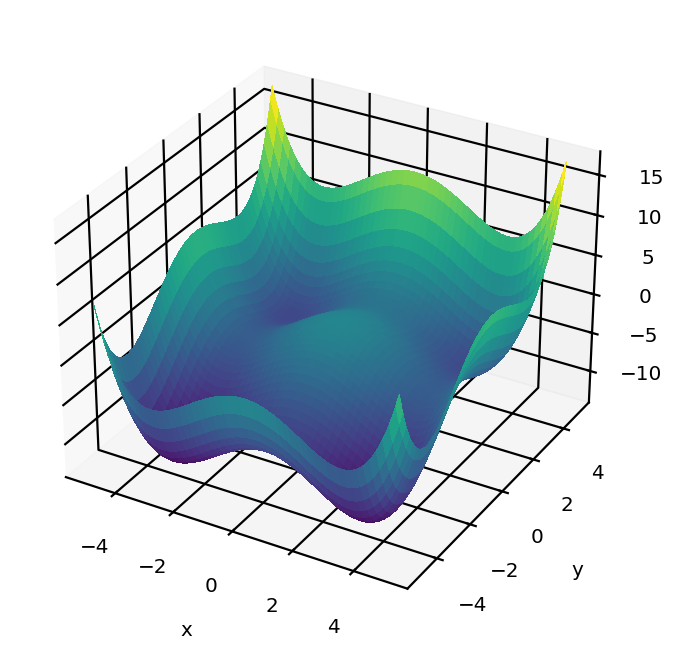

In [2]:
#### import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the double well potential function
def four_well_potential(x, y):
    return 0.05*x**4-x**2+0.05*y**4-(y-0.5)**2

# Define the range of x and y values to plot


x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)

# Create a 2D grid of x and y values
X, Y = np.meshgrid(x, y)

# Calculate the potential energy at each point in the grid
Z = four_well_potential(X, Y)

# Create a 3D surface plot of the potential energy
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Potential Energy')

plt.show()

In [4]:

import numpy as np
import matplotlib.pyplot as plt

# Define the parameters of the simulation
k1 = 0.05  
k2= 0.05
T = 1.0  # Temperature
gamma = 0.1  # Damping coefficient
dt = 0.01  # Time step
tmax = 100.0  # Maximum simulation time
x0 = np.array([0, 0.0])  # Initial position

# Define the double well potential
def potential(x):
    return k1*x[0]**4-x[0]**2+k2*x[1]**4-(x[1]-0.5)**2

# Define the gradient of the potential
def gradient(x):
    return np.array([4*k1*x[0]**3-2*x[0],4*k2*x[1]**3-2*x[1]+1])

# Define the stochastic force
def stochastic_force(x):
    return 0.08*np.sqrt(2.0 * gamma * T / dt) * np.random.normal(size=2)

# Initialize the particle position and velocity


# Initialize the time and trajectory arrays

trajs=[]

for tl in range(100):
    # Perform the simulation using the Euler-Maruyama method
    
    x = x0
    v = np.zeros(2)
    t = np.arange(0.0, tmax, dt)
    
    tr = np.zeros((len(t), 2))
    tr[0] = x
    
    tr_U= np.zeros((len(t), 1))
    tr_U[0]=potential(x)

    for i in range(1, len(t)):
        # Calculate the deterministic force
        f_d = -gradient(x)

        # Calculate the stochastic force
        f_s = stochastic_force(x)

        # Calculate the position using the Euler method
        x += (f_d*dt + f_s)

        # Update the trajectory array
        tr[i] = x
        tr_U[i] = potential(x)
        
    
    #trajs.append(tr[::200, :])

    trajs.append(np.hstack((tr[::200, :],tr_U[::200,:])))
    # Plot the trajectory of the particle
    plt.scatter(tr[::200, 0], tr[::200, 1],s=1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Trajectory of Particle in Double Well Potential')
plt.show()


In [5]:
X_major=np.concatenate(trajs,axis=0)+4

n_samples=X_major.shape[0]

X_minor=0.1*np.random.randn(n_samples,8)
X=np.hstack((X_major,X_minor))
color_label=np.zeros((n_samples))
color_label[np.argsort(X[:,0])]=np.arange(n_samples)

In [6]:
A = kneighbors_graph(X, 10, mode='connectivity', include_self=True)

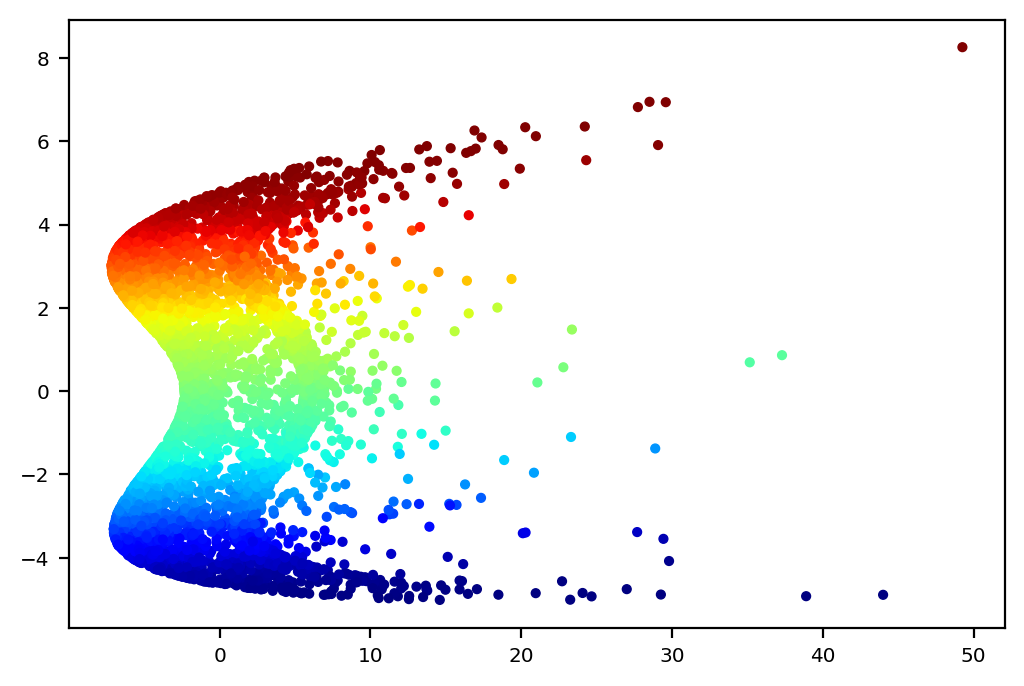

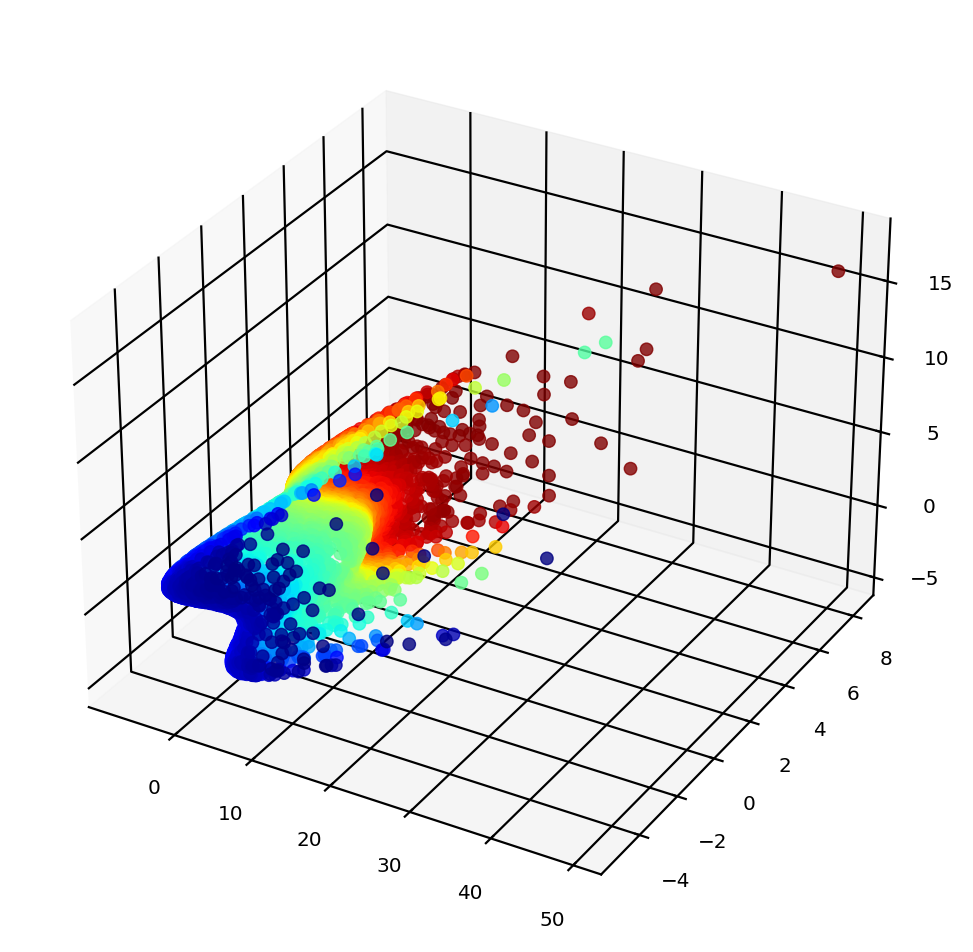

In [7]:
pca=PCA(n_components=3).fit(X)
S_pca=pca.transform(X)
plt.scatter(S_pca[:,0],S_pca[:,1],s=10,c=color_label,cmap=plt.cm.jet)
plt.show()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    S_pca[:, 0],S_pca[:, 1], S_pca[:, 2], c=color_label, s=20, alpha=0.8,cmap=plt.cm.jet
)
plt.show()

In [8]:
epochs = 200
nsamples = 3
learning_rate = 1e-3
seed = 0
n_workers = 4
K =3
#     checkpoint_path = args.checkpoint
#     checkpoints_path = args.checkpoints
#     dataset_path = args.dataset

if seed is not None:
    reset_seeds(seed)

A=A.astype(np.float32)
X=X.astype(np.float32)
z=color_label

n = A.shape[0]
train_nodes, val_nodes = train_test_split(n, train_ratio=1)
A_train = A[train_nodes, :][:, train_nodes]
X_train = X[train_nodes]
z_train = z[train_nodes]
A_val = A[val_nodes, :][:, val_nodes]
X_val = X[val_nodes]
z_val = z[val_nodes]

train_data = AttributedGraph(A_train, X_train, z_train, K)
val_data = AttributedGraph(A_val, X_val, z_val, K)

L = 3
encoder = Encoder(X.shape[1], L)

In [9]:
optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)

iterations = epochs // n_workers
dataset = GraphDataset(train_data, nsamples, iterations)
loader = DataLoader(
    dataset,
    batch_size=1,
    num_workers=n_workers,
    worker_init_fn=reset_seeds,
    collate_fn=lambda args: args,
)

In [10]:
for batch_idx, data in enumerate(loader):
    encoder.train()
    optimizer.zero_grad()

    loss = encoder.compute_loss(data[0][0],data[0][1],data[0][2],data[0][3],data[0][4],data[0][5])
    if batch_idx% 10 == 0:
        print(batch_idx,loss)
    loss.backward()
    optimizer.step()

0 tensor(1.1326e+09, grad_fn=<DivBackward0>)
10 tensor(5.2364e+08, grad_fn=<DivBackward0>)
20 tensor(5.0009e+08, grad_fn=<DivBackward0>)
30 tensor(4.8613e+08, grad_fn=<DivBackward0>)
40 tensor(4.7217e+08, grad_fn=<DivBackward0>)
50 tensor(4.6185e+08, grad_fn=<DivBackward0>)
60 tensor(4.5457e+08, grad_fn=<DivBackward0>)
70 tensor(4.4852e+08, grad_fn=<DivBackward0>)
80 tensor(4.4400e+08, grad_fn=<DivBackward0>)
90 tensor(4.3939e+08, grad_fn=<DivBackward0>)
100 tensor(4.4384e+08, grad_fn=<DivBackward0>)
110 tensor(4.3702e+08, grad_fn=<DivBackward0>)
120 tensor(4.4294e+08, grad_fn=<DivBackward0>)
130 tensor(4.3156e+08, grad_fn=<DivBackward0>)
140 tensor(4.3061e+08, grad_fn=<DivBackward0>)
150 tensor(4.3612e+08, grad_fn=<DivBackward0>)
160 tensor(4.2769e+08, grad_fn=<DivBackward0>)
170 tensor(4.3530e+08, grad_fn=<DivBackward0>)
180 tensor(4.3507e+08, grad_fn=<DivBackward0>)
190 tensor(4.2688e+08, grad_fn=<DivBackward0>)


In [11]:
z=train_data.z
mu, sigma = encoder(train_data.X)
mu_learned = mu.detach().numpy()
sigma_learned = np.sqrt(sigma.detach().numpy())#The learned sigma is variance

In [12]:
sort_idx = z.argsort()

match_idx=sort_idx[np.searchsorted(z,color_label,sorter = sort_idx)]
print(match_idx)

[4765 4547 4317 ... 2154 2981 3017]


In [13]:
X_mu=mu_learned[match_idx]
X_sigma=sigma_learned[match_idx]
X_label=z[match_idx]

In [14]:
latent_z=[]
for i in range(X_mu.shape[1]):
    latent_z.append(X_mu[:,i])
    latent_z.append(X_sigma[:,i])
latent_z=np.array(latent_z).T
latent_z.shape

(5000, 6)

In [15]:
plt.scatter(X_mu[:,0],X_mu[:,1],s=10,c=np.sum(1/X_sigma**2,axis=1),cmap=plt.cm.jet)
plt.colorbar()
plt.show()

plt.scatter(X_mu[:,0],X_mu[:,1],s=10,c=X_label,cmap=plt.cm.jet)
plt.show()


In [16]:
Fisher_g=np.zeros((X.shape[0],L*2,L*2))
for i in range(X.shape[0]):
    for j in range(L):
        Fisher_g[i,2*j,2*j]=1/(X_sigma[i,0]**2)
        Fisher_g[i,2*j+1,2*j+1]=2/(X_sigma[i,0]**2)

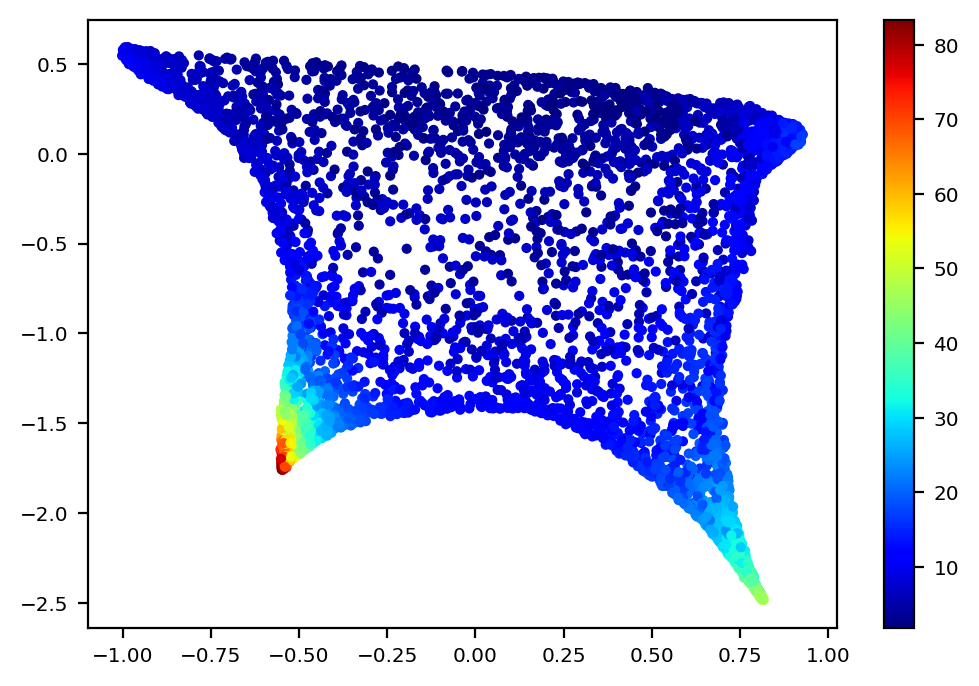

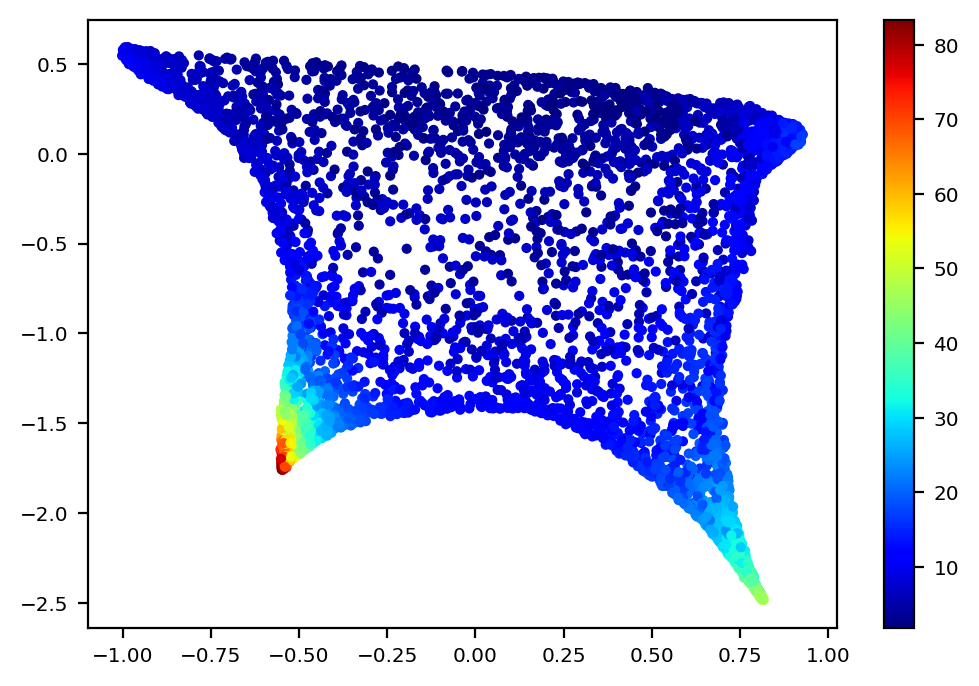

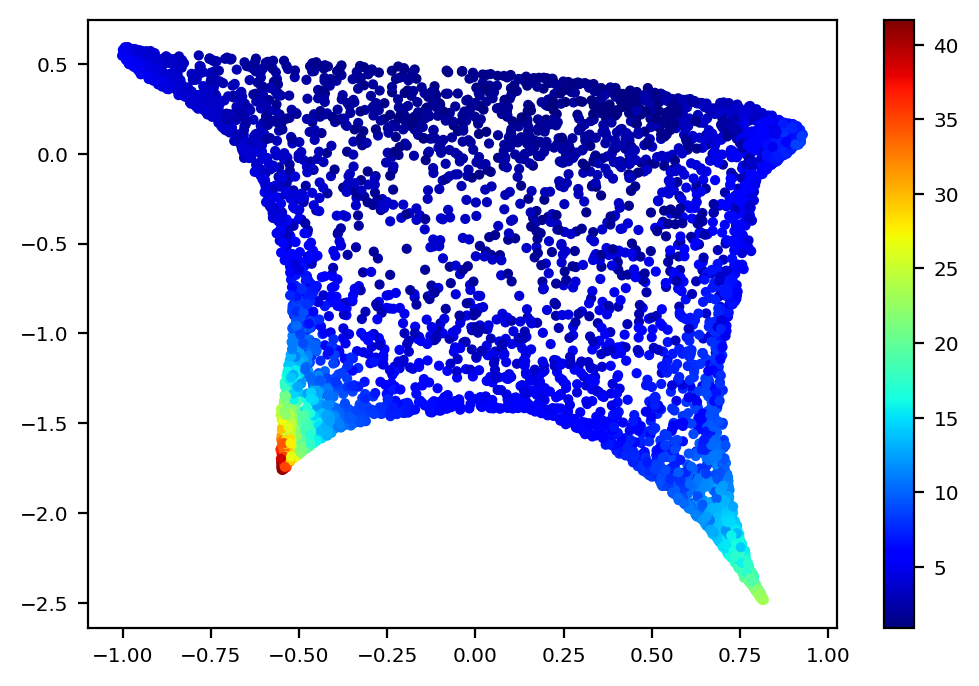

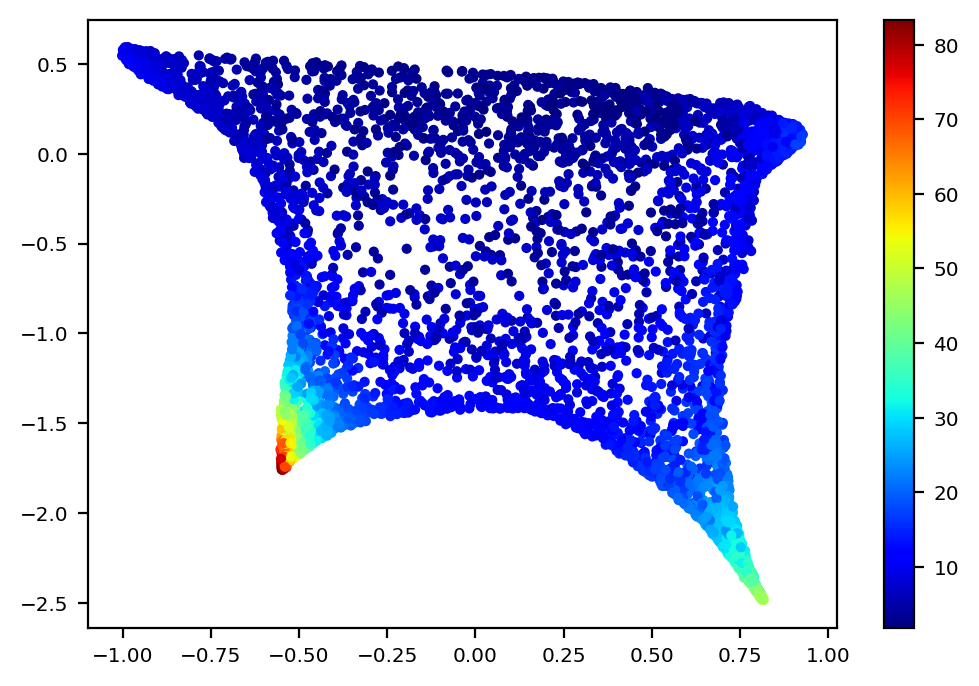

In [17]:
for j in range(L*2):

    plt.scatter(X_mu[:,0],X_mu[:,1],s=10,c=Fisher_g[:,j,j],cmap=plt.cm.jet)
    plt.colorbar()
    plt.show()

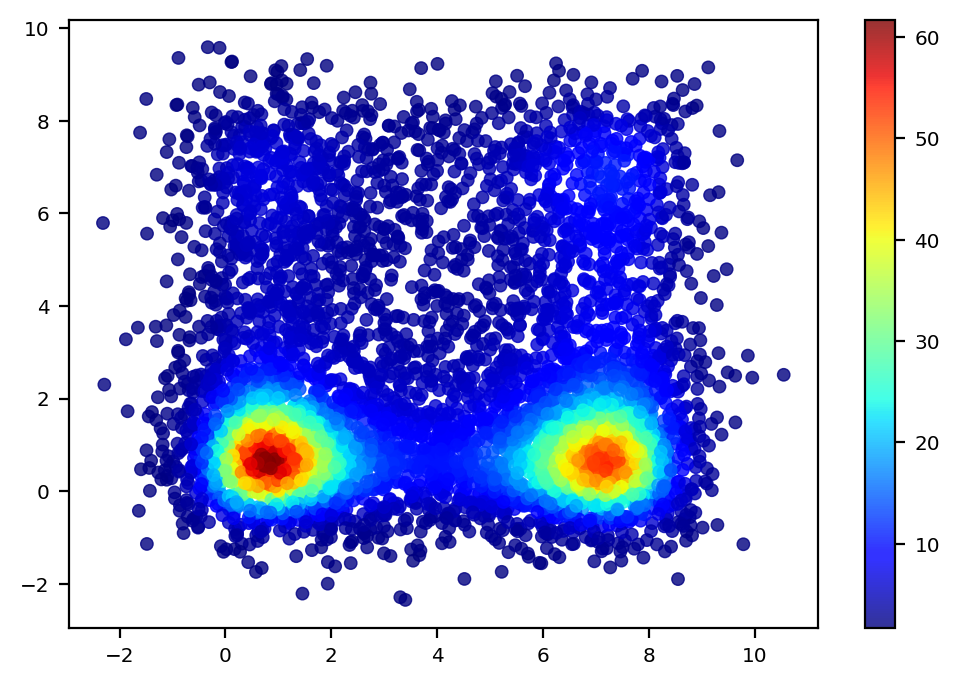

In [18]:
plt.scatter(X[:, 0],X[:, 1], c=color_label, s=20, alpha=0.8,cmap=plt.cm.jet)
plt.show()


plt.scatter(X[:, 0],X[:, 1], c=np.sum(1/X_sigma**2,axis=1), s=20, alpha=0.8,cmap=plt.cm.jet)
plt.colorbar()
plt.show()

In [19]:
def Fisher_dist(mu1,sigma1,mu2,sigma2):
    dim=len(mu1)
    dF2=0
    for i in range(dim):
        a=np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]+sigma2[i])**2)+\
          np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]-sigma2[i])**2)
        b=np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]+sigma2[i])**2)-\
          np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]-sigma2[i])**2)
        
        dF2+=2*(np.log(a/b))**2
    dF=np.sqrt(dF2)
    return dF

In [20]:
def KL_dist(mu1,sigma1,mu2,sigma2):
    dim=len(mu1)
    dmu=mu1-mu2
    KL_dist=0
    for i in range(dim):
        #the after KL_12+KL_21 the log(det(sigma1)/det(sigma2))+log(det(sigma2)/det(sigma1))=0
        # so do not calculate this term
        KL_12=1/2*(-1+sigma1[i]**2/sigma2[i]**2+dmu[i]**2/sigma2[i]**2)
        KL_21=1/2*(-1+sigma2[i]**2/sigma1[i]**2+dmu[i]**2/sigma1[i]**2)
        KL_sym=KL_12+KL_21
        KL_dist+=KL_sym
    return KL_dist

In [21]:
#-------------calcualte distance pair--------------
dist_ratios=[]
for inds in np.split(A.indices, A.indptr)[1:-1]:

    dist_r=[]
    self_ind=inds[0]
    for nei_k in range(1,len(inds)):
        
        dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])
        dFi=Fisher_dist(X_mu[self_ind,:],X_sigma[self_ind,:],\
                        X_mu[inds[nei_k],:],X_sigma[inds[nei_k],:])

        gau_dEu=np.linalg.norm(X_mu[self_ind,:]-X_mu[inds[nei_k],:])
        
        dKL=KL_dist(X_mu[self_ind,:],X_sigma[self_ind,:],\
                        X_mu[inds[nei_k],:],X_sigma[inds[nei_k],:])
        
        dist_r.append(dEu/dFi)

        
        
#     print(np.std(dist_r)/np.mean(dist_r))
    
    dist_ratios.append(np.std(dist_r)/np.mean(dist_r))

plt.hist(np.array(dist_ratios),bins=100,edgecolor='black')
plt.show()

In [22]:
def wasserstein_distance(mu1,sigma1,mu2,sigma2):
    dim=len(mu1)
    dmu=mu1-mu2
    W_dist2=0
    for i in range(dim):
        W_dist2+=dmu[i]**2+sigma1[i]**2+sigma2[i]**2-2*np.sqrt(sigma2[i]*sigma1[i]**2*sigma2[i])
    W_dist=np.sqrt(W_dist2)
    return W_dist

In [25]:
cRc_arr=[]
for inds in np.split(A.indices, A.indptr)[1:-1]:

    self_ind=inds[0]
    cRc=0
    for nei_k in range(1,len(inds)):
        
        dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])
        dFi=Fisher_dist(X_mu[self_ind,:],X_sigma[self_ind,:],\
                        X_mu[inds[nei_k],:],X_sigma[inds[nei_k],:])
        dWa=wasserstein_distance(X_mu[self_ind,:],X_sigma[self_ind,:],\
                        X_mu[inds[nei_k],:],X_sigma[inds[nei_k],:])
        
        cRc+=1-dWa/dEu
    
    cRc_arr.append(cRc/len(inds))
#     cRc_arr.append(cRc)

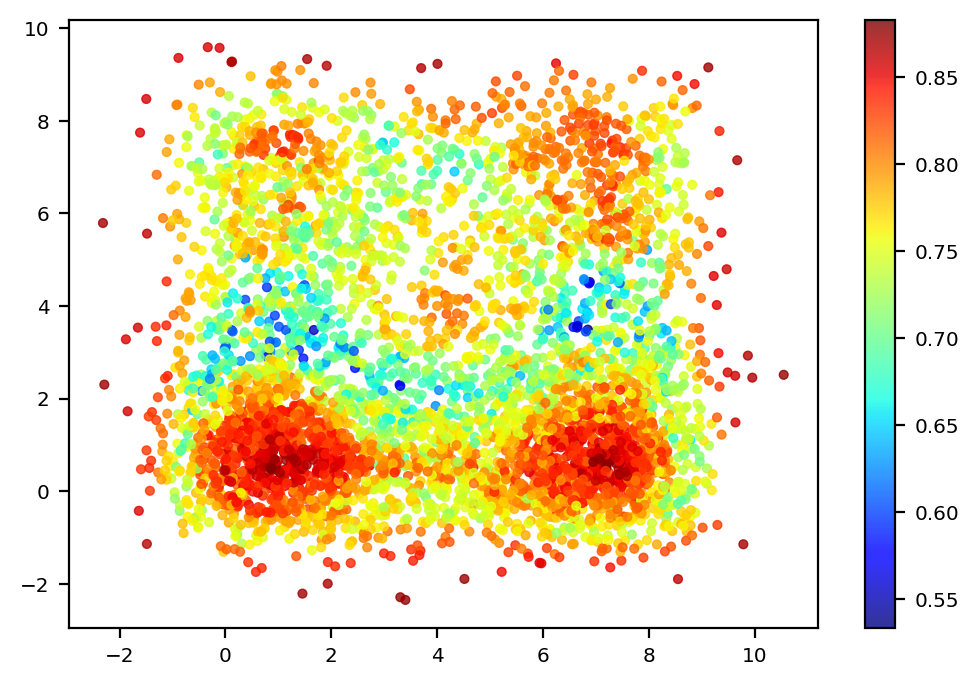

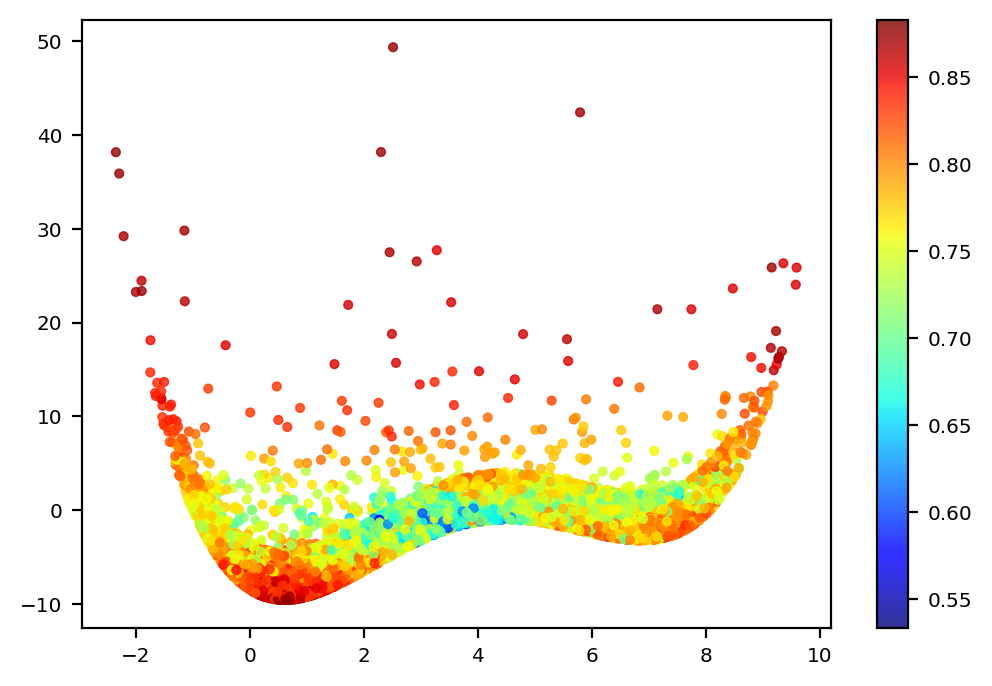

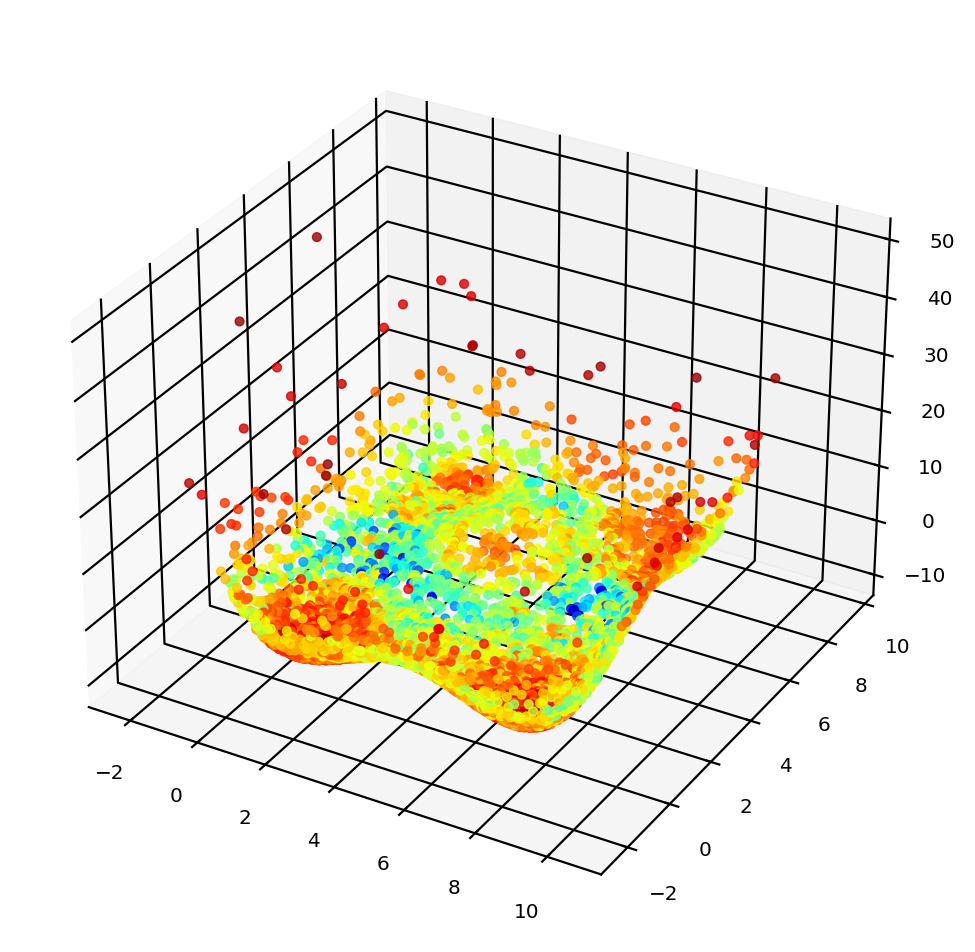

In [26]:
plt.scatter(X[:, 0],X[:, 1], c=cRc_arr, s=10, alpha=0.8,cmap=plt.cm.jet)
plt.colorbar()
plt.show()

plt.scatter(X[:,1],X[:, 2], c=cRc_arr, s=10, alpha=0.8,cmap=plt.cm.jet)
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    X[:, 0],X[:, 1], X[:, 2], c=cRc_arr, s=10, alpha=0.8,cmap=plt.cm.jet
)
plt.show()